In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cosine
from sktime.datasets import load_airline
from sktime.transformations.series.adapt import TabularToSeriesAdaptor
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
from sktime.transformations.series.detrend import Detrender
from sktime.transformations.series.detrend import Deseasonalizer
from sktime.pipeline import make_pipeline

In [17]:
import os
dir_path = 'time_series/'
len_threshold = 1400

In [18]:

import numpy as np

# Carica i dati
X = np.load('X_finale.npy')
y = np.load('y_finale.npy')
ids = np.load('ids_finale.npy')

# Inizializza le variabili per tenere traccia dei sample per genere
genre_count = {}

# Inizializza le liste per i nuovi dati estratti
X_sampled, y_sampled, ids_sampled = [], [], []

# Numero massimo di sample per genere
max_samples_per_genre = 500

# Loop attraverso i dati per selezionare 100 sample per genere
for i in range(len(X)):
    genre = y[i]
    if genre not in genre_count:
        genre_count[genre] = 0

    # Se non abbiamo ancora selezionato 100 sample per questo genere
    if genre_count[genre] < max_samples_per_genre:
        X_sampled.append(X[i])
        y_sampled.append(y[i])
        ids_sampled.append(ids[i])
        genre_count[genre] += 1

    # Se abbiamo già selezionato 100 sample per questo genere, passiamo al prossimo
    else:
        continue

# Converti le liste in numpy arrays
X_sampled = np.array(X_sampled)
y_sampled = np.array(y_sampled)
ids_sampled = np.array(ids_sampled)




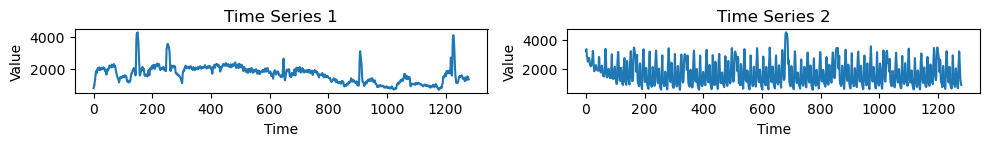

In [19]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

In [20]:
len_threshold = 1280   #cause >1280 no infos in ts 

In [21]:
# Ottieni i valori unici e le loro frequenze
valori_unici, conteggi = np.unique(y_sampled, return_counts=True)

# Stampare il numero di volte che ogni classe appare
for classe, conteggio in zip(valori_unici, conteggi):
    print(f"{classe}: {conteggio}")

emo: 500
folk: 500
goth: 500
happy: 500
heavy-metal: 500
honky-tonk: 500
j-idol: 500
kids: 500
minimal-techno: 500
mpb: 500
new-age: 500
opera: 500
piano: 500
progressive-house: 500
salsa: 500
sertanejo: 500
sleep: 500
songwriter: 500
synth-pop: 500
world-music: 500


In [22]:
import numpy as np

# Conta il numero di generi unici presenti nella lista y
unique_genres = np.unique(y_sampled)
num_unique_genres = len(unique_genres)

print("Numero di generi unici:", num_unique_genres)
print('generi unici:', unique_genres)


Numero di generi unici: 20
generi unici: ['emo' 'folk' 'goth' 'happy' 'heavy-metal' 'honky-tonk' 'j-idol' 'kids'
 'minimal-techno' 'mpb' 'new-age' 'opera' 'piano' 'progressive-house'
 'salsa' 'sertanejo' 'sleep' 'songwriter' 'synth-pop' 'world-music']


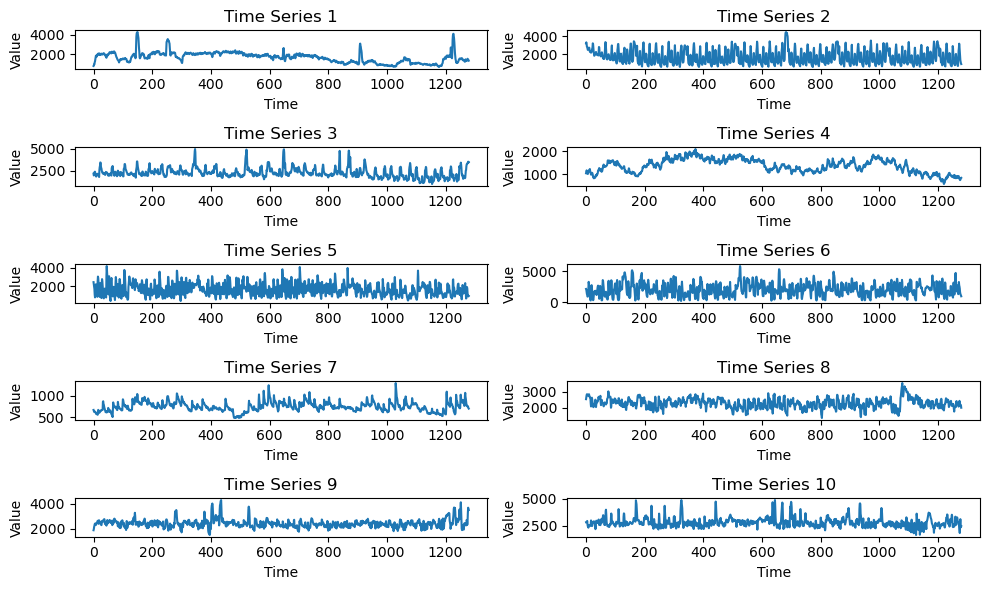

In [23]:
# Plot the first 10 time series
plt.figure(figsize=(10, 6))
for i in range(10):
    plt.subplot(5, 2, i+1)  # 5 rows, 2 columns, i+1 is the plot index
    plt.plot(X_sampled[i][0])  # Assuming X is a list of lists where each inner list contains a single time series
    plt.title(f"Time Series {i+1}")
    plt.xlabel("Time")
    plt.ylabel("Value")
plt.tight_layout()
plt.show()

## Trasformazioni (amplitude scaling, noise) win size= 100

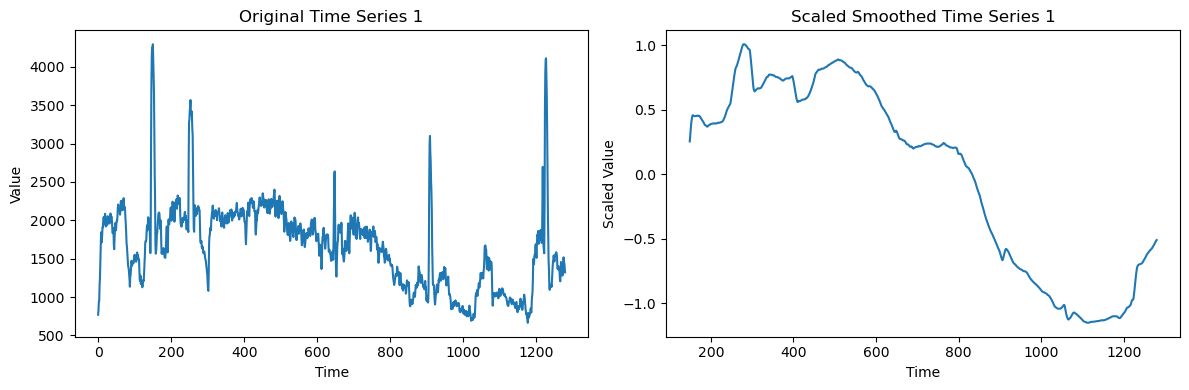

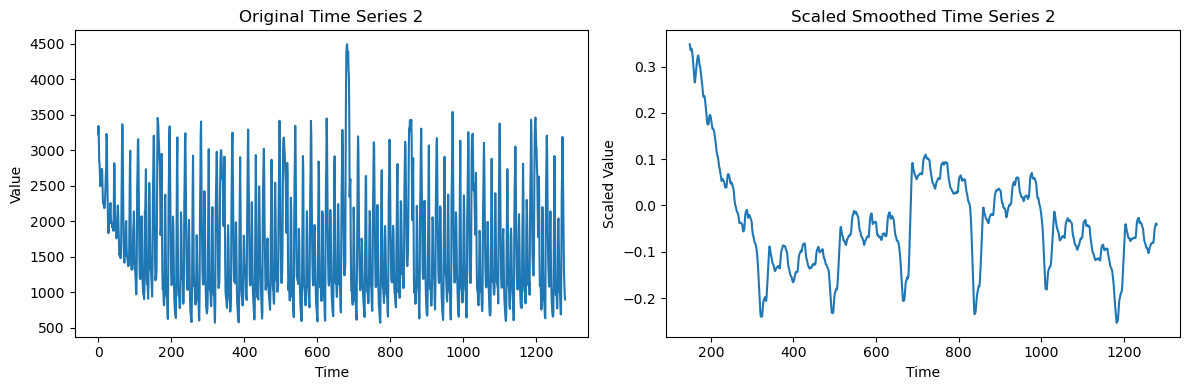

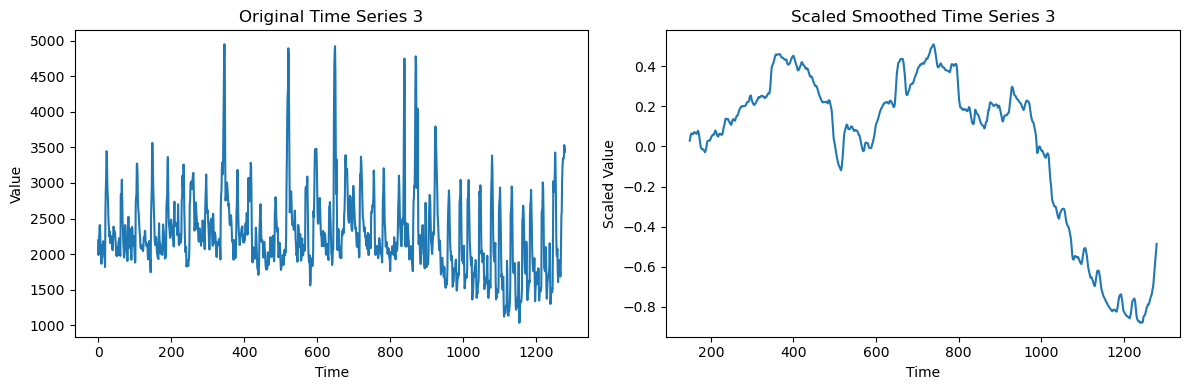

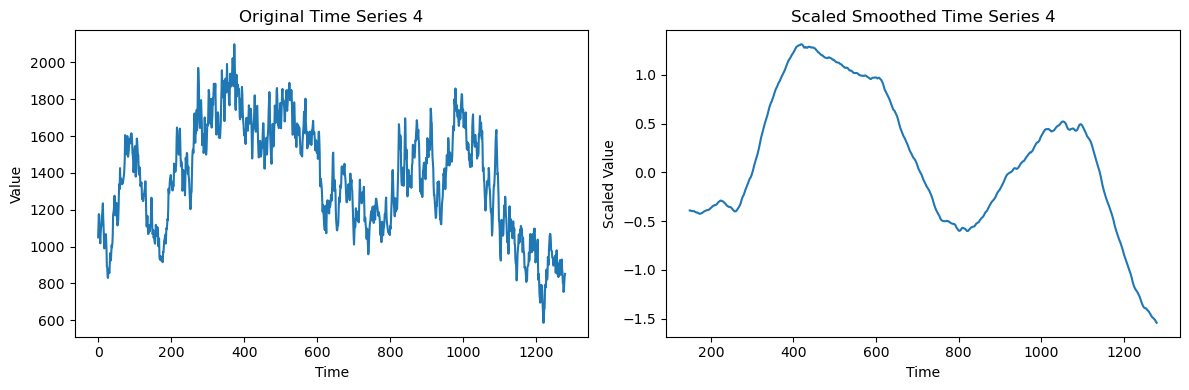

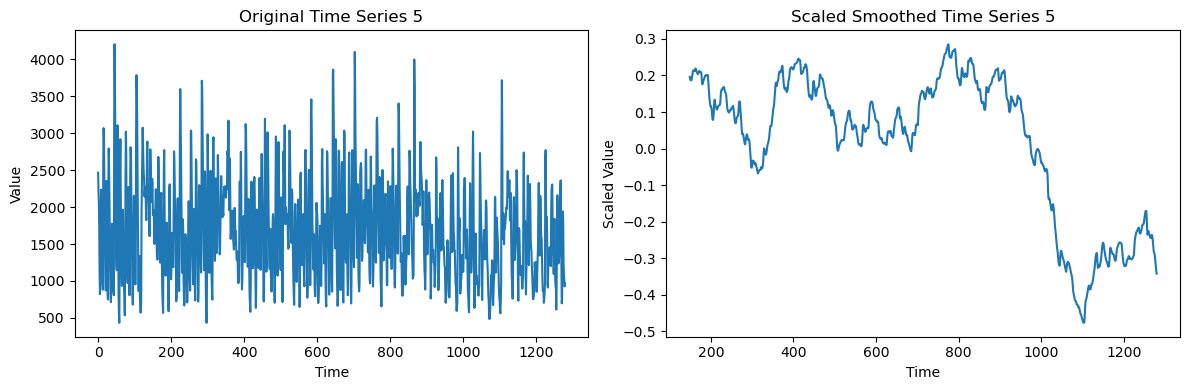

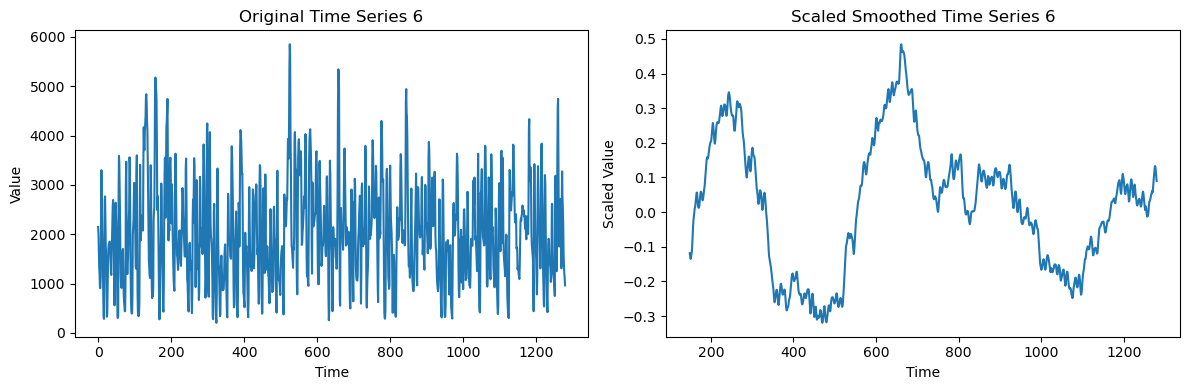

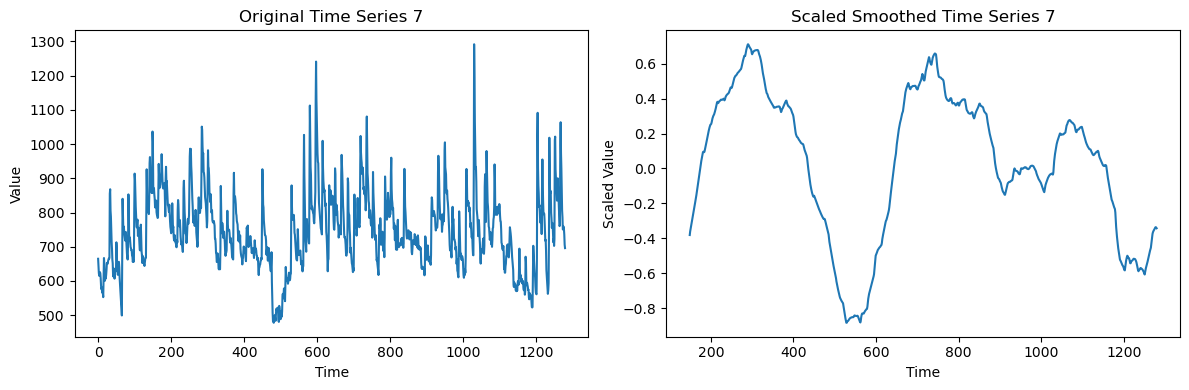

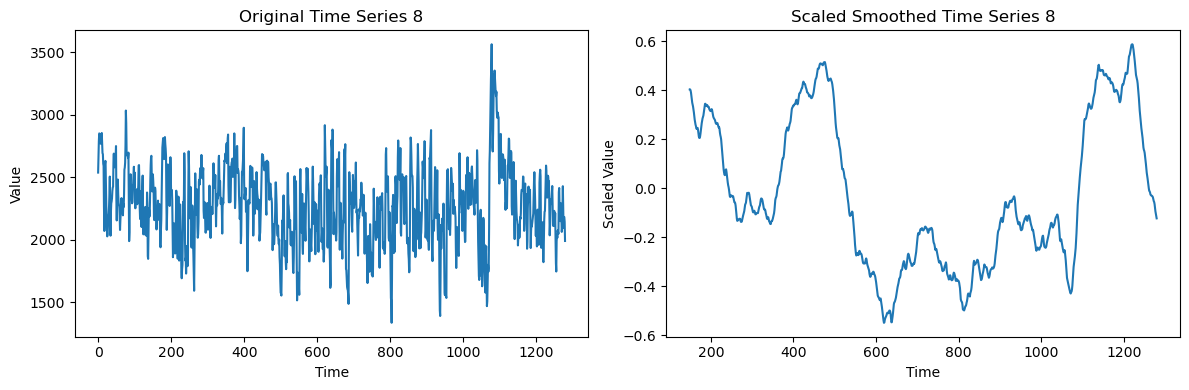

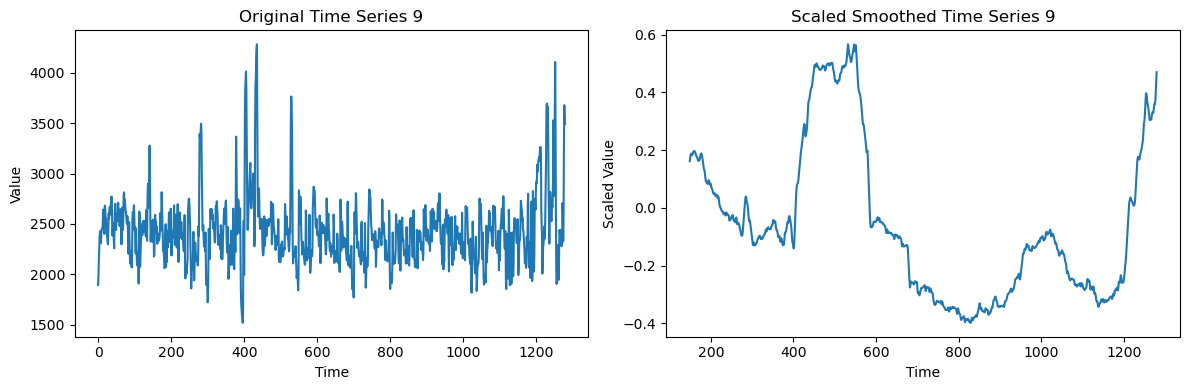

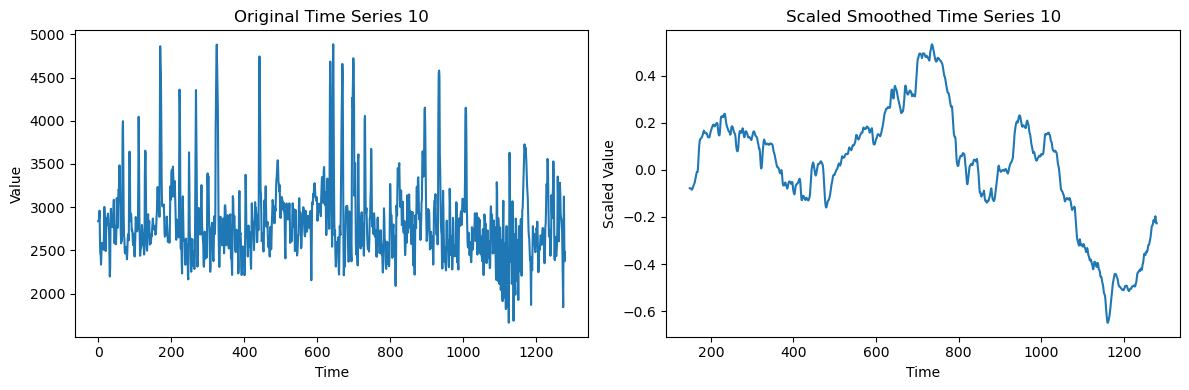

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler

# Define window size for rolling mean
w = 150

# Assume X contains the time series data for the first 10 time series
scaler = StandardScaler()

for i in range(10):
    ts = X_sampled[i][0]  # Assuming X is a list of lists where each inner list contains a single time series
    
    # Scale the time series
    tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
    
    # Mean centering and standardization
    ts_scaled = ((tss - tss.mean()) / tss.std())
    
    # Apply rolling window mean
    ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w).mean()
    
    # Plot comparison subplot
    plt.figure(figsize=(12, 4))
    
    # Plot original time series
    plt.subplot(1, 2, 1)
    plt.plot(ts)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.title(f"Original Time Series {i+1}")
    
    # Plot scaled and smoothed time series
    plt.subplot(1, 2, 2)
    plt.plot(ts_smoothed)
    plt.xlabel("Time")
    plt.ylabel("Scaled Value")
    plt.title(f"Scaled Smoothed Time Series {i+1}")
    
    plt.tight_layout()
    plt.show()


## Reconstruct Error on PAA approx

In [25]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import StandardScaler

# Define your time series data in X

# Define window size for rolling mean
w_values = [5, 10, 100, 150, 180, 250]

original_series_list = []
scaled_series_list = []
smoothed_series_list = []
euclidean_distance_list = []

min_distance = float('inf')  # Initialize min_distance with infinity
best_w = None

for w in w_values:
    scaled_series_per_w = []  # List to store scaled series for the current window size
    smoothed_series_per_w = []  # List to store smoothed series for the current window size
    original_series_per_w = []  # List to store reconstructed series for the current window size
    
    distance_sum = 0
    for i in range(len(X_sampled)):
        ts = X_sampled[i][0]  # Assuming X is a list of time series
        
        # Scale the time series
        scaler = StandardScaler()
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))
        
        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())
        
        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()
            
        # Capture noise (difference between scaled and smoothed series)
        noise = ts_scaled.squeeze() - ts_smoothed
        
        # Reconstruct the original time series by adding back the noise
        original_series = ts_smoothed + noise

        # Append the current time series to the lists for the current window size
        scaled_series_per_w.append(ts_scaled)
        smoothed_series_per_w.append(ts_smoothed)
        original_series_per_w.append(original_series)

        
        # Calculate Euclidean distance between original and smoothed time series
        distance = pairwise_distances(ts_scaled.flatten().reshape(1, -1), np.array(original_series).flatten().reshape(1, -1), metric='euclidean')
        distance_sum += distance

    # Calculate average Euclidean distance for the current window size
    avg_distance = distance_sum / len(X_sampled)
    euclidean_distance_list.append(avg_distance)
    
    # Update min_distance and best_w if the current average distance is smaller than min_distance
    if avg_distance < min_distance:
        min_distance = avg_distance
        best_w = w
        
    # Append the lists for the current window size to the main lists
    scaled_series_list.append(scaled_series_per_w)
    smoothed_series_list.append(smoothed_series_per_w)
    original_series_list.append(original_series_per_w)

# Print best window size and corresponding minimum Euclidean distance
print("Best window size:", best_w)
print("Minimum Euclidean distance:", min_distance)


Best window size: 5
Minimum Euclidean distance: [[4.59314432e-07]]


In [26]:
# Find the index of the best window size in w_values
best_w_index = w_values.index(best_w)

w = 150 #150

# Select the lists corresponding to the best window size
best_scaled_series_list = scaled_series_list[best_w_index]
best_smoothed_series_list = smoothed_series_list[best_w_index]
best_original_series_list = original_series_list[best_w_index]

# Now you can use best_scaled_series_list, best_smoothed_series_list, and best_original_series_list
# for further analysis or visualization

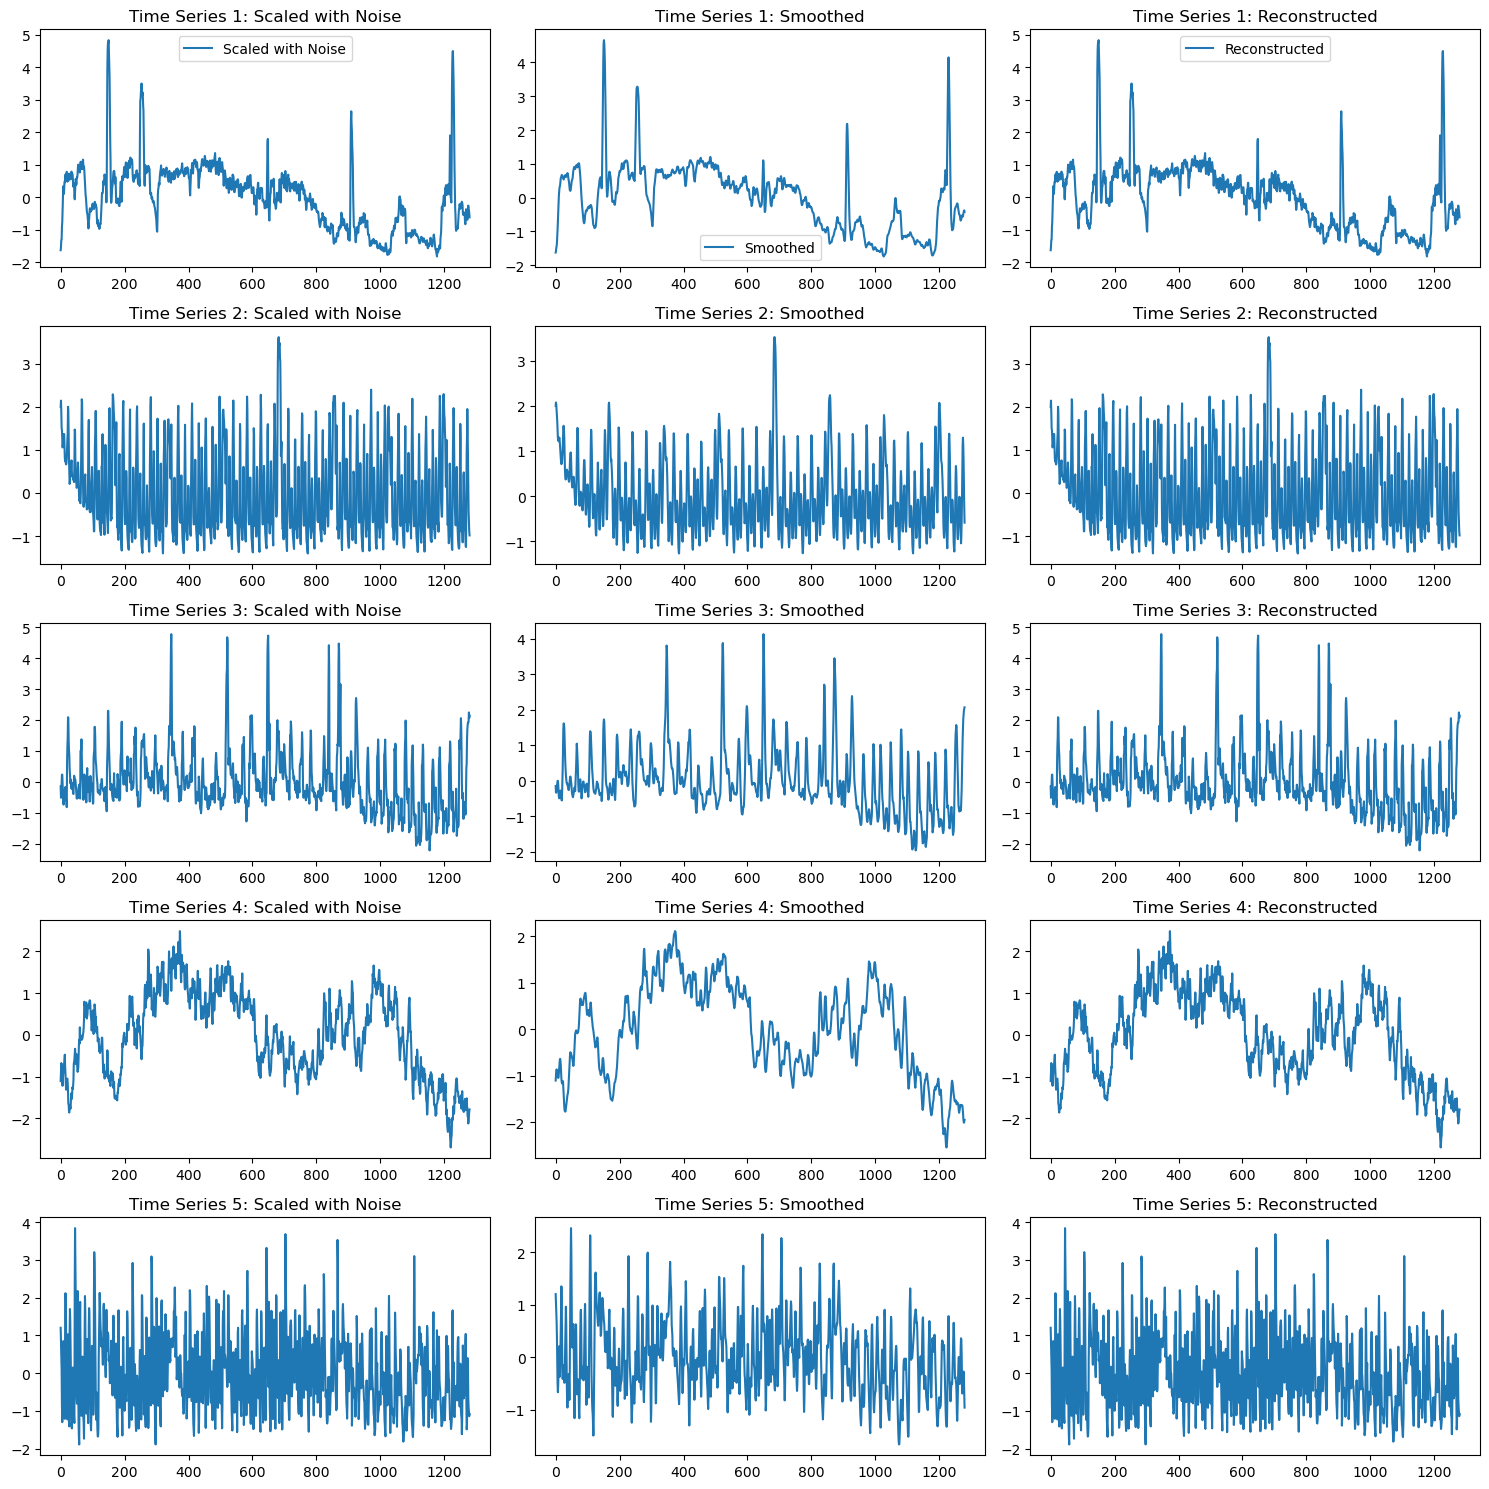

In [27]:
# Plot the scaled time series with noise and the reconstructed time series side by side
num_series_to_plot = (5)  # Plot at most 50 time series or the number available
num_plots = 3  # Three plots per time series: scaled with noise, smoothed, and reconstructed

if num_series_to_plot > 0:
    plt.figure(figsize=(15, num_series_to_plot*3))

    for i in range(num_series_to_plot):
        for j in range(num_plots):
            plt.subplot(num_series_to_plot, num_plots, i * num_plots + j + 1)
            if j == 0:
                plt.plot(best_scaled_series_list[i], label='Scaled with Noise')
                plt.title(f'Time Series {i+1}: Scaled with Noise')
            elif j == 1:
                plt.plot(best_smoothed_series_list[i], label='Smoothed')
                plt.title(f'Time Series {i+1}: Smoothed')
            else:
                plt.plot(best_original_series_list[i], label='Reconstructed')
                plt.title(f'Time Series {i+1}: Reconstructed')
            if i == 0:
                plt.legend()

    plt.tight_layout()
    plt.show()
else:
    print("No time series available for plotting.")


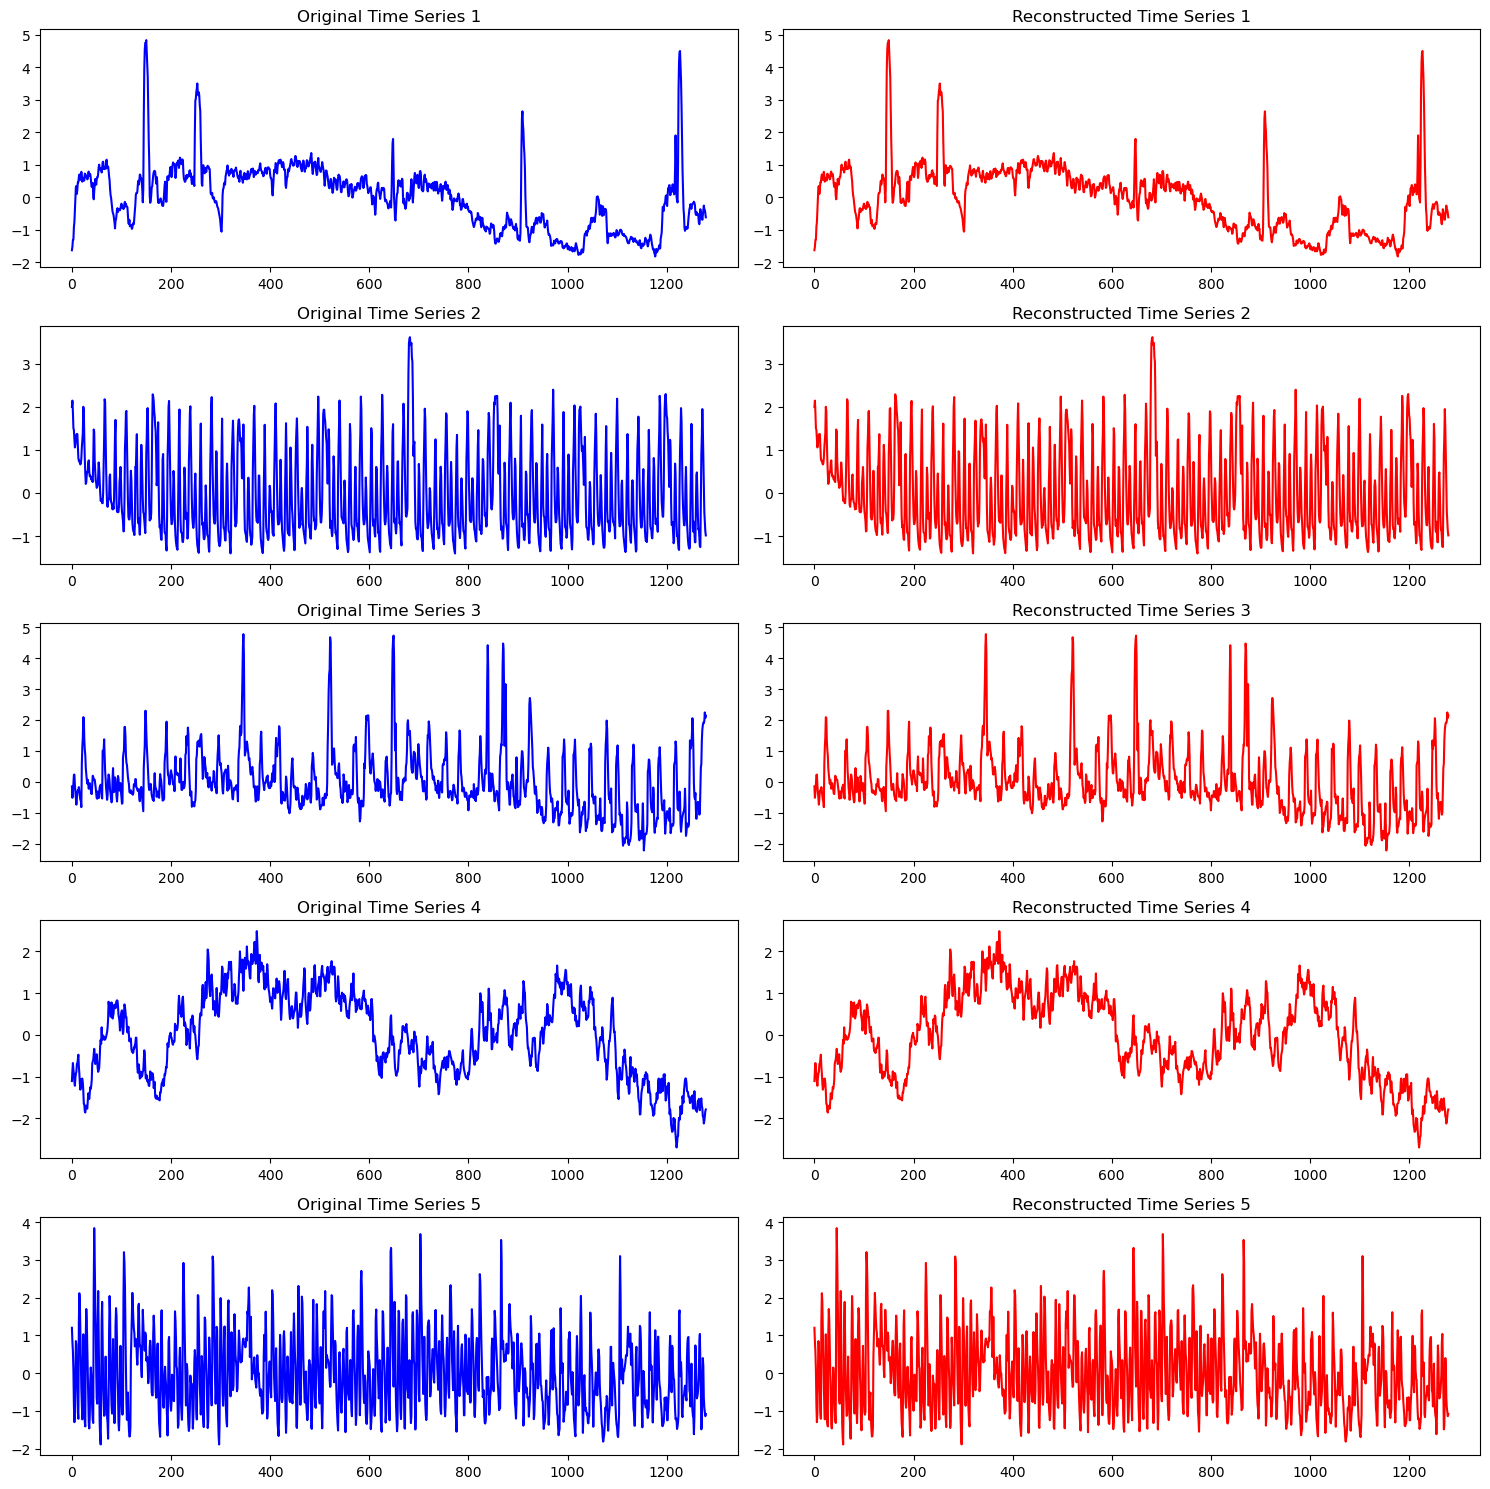

In [28]:
import matplotlib.pyplot as plt

# Assuming original_series_list contains the reconstructed original time series
# and X contains the original time series data

# Plotting the time series side by side
num_samples = 5  # Number of time series to plot

fig, axs = plt.subplots(num_samples, 2, figsize=(15, num_samples*3))

for i in range(num_samples):
    # Original time series
    axs[i, 0].plot(best_scaled_series_list[i], color='blue', label='Original')
    axs[i, 0].set_title('Original Time Series ' + str(i+1))
    
    # Reconstructed time series
    axs[i, 1].plot(best_original_series_list[i], color='red', label='Reconstructed')
    axs[i, 1].set_title('Reconstructed Time Series ' + str(i+1))

plt.tight_layout()
plt.show()


In [29]:
d=np.array(smoothed_series_per_w)

In [30]:
d.shape

(10000, 1280)

In [31]:
np.save('time_series_distanza_euclidea_500.npy', d)
np.save('generi_500.npy', y_sampled)
np.save('ids_500.npy', ids_sampled)

## Find best PAA intervals

The best interval value is: 160
Minimum euclidean distance: 1.052249163613103


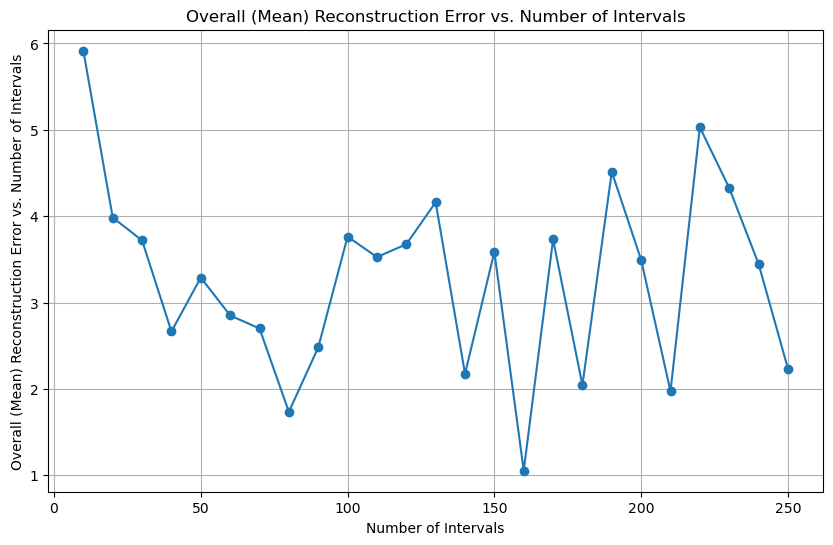

In [32]:
from tslearn.piecewise import PiecewiseAggregateApproximation
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean

# Define a function to calculate Euclidean distance
def calculate_euclidean_distance(x1, x2):
    return np.sqrt(np.sum((x1 - x2) ** 2))

# Initialize a list to store average distances for different values of num_intervals
avg_distances = []

# Initialize a list to store the distances for the best interval
distances_for_best_interval = []

# Iterate over each time series in X
for series_list in X_sampled:

    # Initialize a list to store average distances for different values of num_intervals for the current series
    avg_distances_series = []

    # Try different values of num_intervals
    for num_intervals in range(10, 251, 10):  # Try intervals from 10 to 250

        # Select the first time series
        ts = series_list[0]  # Assuming each series_list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # New dataframe for ts_smoothed
        df = pd.DataFrame(ts_smoothed)
        df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
        ts_paa = paa.fit_transform(df_values)

        # Invert PAA transformation
        inverse_paa = paa.inverse_transform(ts_paa)

        # Invert scaling transformation
        reconstructed_series = inverse_paa.squeeze()

        # Calculate Euclidean distance between smoothed and reconstructed time series
        distance = calculate_euclidean_distance(ts_smoothed, reconstructed_series)

        # Append the distance to the list
        avg_distances_series.append(distance)

    # Append the average distances for the current series to the overall list
    avg_distances.append(avg_distances_series)

# Calculate the overall average distances across all time series for each num_intervals
overall_avg_distances = np.mean(avg_distances, axis=0)

# Find the index of the minimum overall average Euclidean distance
best_interval_index = np.argmin(overall_avg_distances)

# Calculate the corresponding best num_intervals
best_interval = 10 + best_interval_index * 10  # Because the intervals start from 10 and increase by 10

# Obtain the minimum Euclidean distance
min_euclidean_distance = overall_avg_distances[best_interval_index]

# Print the best interval value and the corresponding minimum Euclidean distance
print("The best interval value is:", best_interval)
print("Minimum euclidean distance:", min_euclidean_distance)

# Plot the overall average distances for different values of num_intervals
plt.figure(figsize=(10, 6))
plt.plot(range(10, 251, 10), overall_avg_distances, marker='o', linestyle='-')
plt.title('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.xlabel('Number of Intervals')
plt.ylabel('Overall (Mean) Reconstruction Error vs. Number of Intervals')
plt.grid(True)
plt.show()


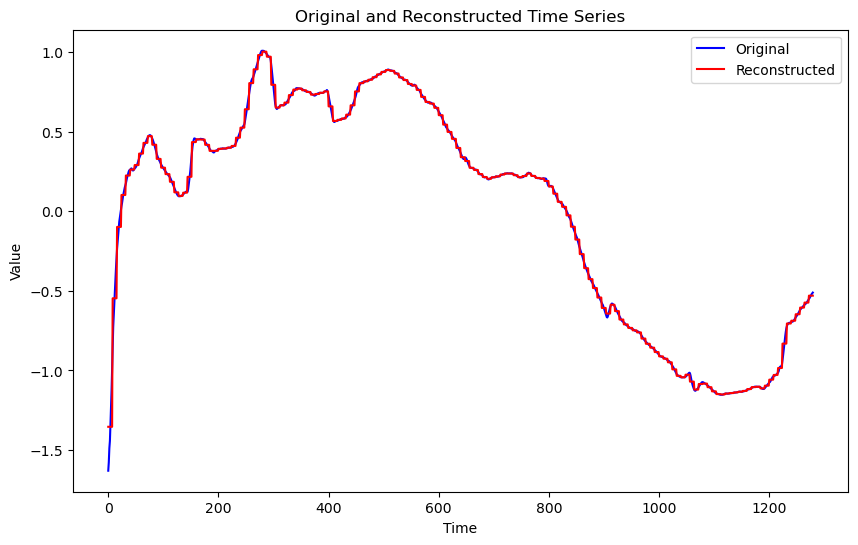

In [33]:
# Define window size for rolling mean
w = 150  # Best value from previous studies

# best value from previous studies
num_intervals = 160

# Select one time series from X
ts = X_sampled[0][0]  # Assuming X is a list of lists where each inner list contains a single time series

# Initialize scaler
scaler = StandardScaler()

# Scale the time series
tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

# Mean centering and standardization (amplitude scaling)
ts_scaled = ((tss - tss.mean()) / tss.std())

# Apply rolling window mean (noise)
ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

# New dataframe for ts_smoothed
df = pd.DataFrame(ts_smoothed)
df_values = df.values.reshape(1, -1, 1)  # Reshape to 3D array (n_samples, n_timestamps, n_features)

# Perform Piecewise Aggregate Approximation (PAA)
paa = PiecewiseAggregateApproximation(n_segments=num_intervals)
ts_paa = paa.fit_transform(df_values)

# Invert PAA transformation
inverse_paa = paa.inverse_transform(ts_paa)

# Invert scaling transformation
reconstructed_series = inverse_paa.squeeze()

# Plot original and reconstructed time series
plt.figure(figsize=(10, 6))
plt.plot(ts_smoothed, label='Original', color='blue')
plt.plot(reconstructed_series, label='Reconstructed', color='red')
plt.title('Original and Reconstructed Time Series')
plt.xlabel('Time')
plt.ylabel('Value')
plt.legend()
plt.show()


## Preprocess TS with best values so far¶

In [34]:
from sktime.transformations.panel.dictionary_based import PAA

In [35]:
w=150 
best_intervals=160 # from past studies
ts_paa_list = []

for i in range(len(X_sampled)):
        ts = X_sampled[i][0]  # Assuming X is a list of lists where each inner list contains a single time series

        # Scale the time series
        tss = scaler.fit_transform(np.array(ts).reshape(-1, 1))

        # Mean centering and standardization (amplitude scaling)
        ts_scaled = ((tss - tss.mean()) / tss.std())

        # Apply rolling window mean (noise)
        ts_smoothed = pd.Series(ts_scaled.squeeze()).rolling(window=w, min_periods=1).mean()

        # Perform Piecewise Aggregate Approximation (PAA)
        paa = PAA(num_intervals=best_intervals)
        ts_paa = paa.fit_transform(pd.DataFrame(ts_smoothed)).iloc[:, 0].values
        ts_paa_list.append([ts_paa])

In [36]:
ts_paa_vect = np.array(ts_paa_list)

In [38]:
# salva serie temporali normalizzate
#salvo i valori ottenuti
import numpy as np
import pandas as pd

# Assume che X, y e ids siano già definiti

# Salva i numpy array separatamente
np.save('X_finale_normalizzato_500.npy', ts_paa_vect)
#np.save('y_finale_normalizzato_500.npy', y_sampled)
#np.save('ids_finale_normalizzato_500.npy', ids_sampled)

